In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import autokeras as ak
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# Загружаем данные из CSV файла
file_path = "ticket2.csv"  # путь к загруженному файлу
df = pd.read_csv(file_path)

# Вывод первых нескольких строк данных и информации о данных
print("Первые строки данных:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())
print("\nКоличество дубликатов в данных:")
print(df.duplicated().sum())
print("\nКоличество пустых значений по каждому столбцу:")
print(df.isnull().sum())

# Убираем возможные дубликаты
df.drop_duplicates(inplace=True)

# Заменим пустые значения на пустые строки только в нужных столбцах
df['text'].fillna('', inplace=True)
df['queue'].fillna('', inplace=True)

# Проверка наличия данных после предобработки
if df.empty:
    raise ValueError("После предобработки данные пусты. Проверьте исходные данные.")

# Проверка наличия необходимых столбцов
required_columns = ['text', 'queue']
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Столбец {col} отсутствует в данных.")


Первые строки данных:
        queue  priority software_used   hardware_used  \
0    Hardware         2           NaN  Wireless Mouse   
1    Hardware         2           NaN          IP PBX   
2    Hardware         2           NaN    SFX-Netzteil   
3  Accounting         2           NaN             NaN   
4    Software         2      Arbitrum             NaN   

                     accounting_category language  \
0                                    NaN       en   
1                                    NaN       fr   
2                                    NaN       de   
3  Customer Inquiries::Technical Support       en   
4                                    NaN       en   

                                 subject  \
0  Wireless Mouse suddenly stops working   
1          Problème de connexions IP PBX   
2        Problem mit meinem SFX-Netzteil   
3             Invoice Adjustment Request   
4    Issue with Arbitrum: UI not loading   

                                                tex

In [ ]:
# Разделим данные на обучающую и тестовую выборки
X_train, X_tmp, y_train, y_tmp = train_test_split(np.array(df['text']), np.array(df['queue']), test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)


In [ ]:
# Обучение модели
clf = ak.TextClassifier(overwrite=True, max_trials=2, objective='val_accuracy')
result_training = clf.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))


Trial 2 Complete [00h 00m 08s]
val_accuracy: 0.46666666865348816

Best val_accuracy So Far: 0.699999988079071
Total elapsed time: 00h 00m 14s
Epoch 1/20
5/5 [==============================] - 2s 150ms/step - loss: 1.0907 - accuracy: 0.4143 - val_loss: 1.0854 - val_accuracy: 0.4000
Epoch 2/20
5/5 [==============================] - 0s 43ms/step - loss: 1.0768 - accuracy: 0.4214 - val_loss: 1.0846 - val_accuracy: 0.4000
Epoch 3/20
5/5 [==============================] - 0s 46ms/step - loss: 1.0751 - accuracy: 0.4286 - val_loss: 1.0837 - val_accuracy: 0.4000
Epoch 4/20
5/5 [==============================] - 0s 42ms/step - loss: 1.0677 - accuracy: 0.4143 - val_loss: 1.0824 - val_accuracy: 0.4000
Epoch 5/20
5/5 [==============================] - 0s 32ms/step - loss: 1.0509 - accuracy: 0.4429 - val_loss: 1.0809 - val_accuracy: 0.4000
Epoch 6/20
5/5 [==============================] - 0s 104ms/step - loss: 1.0419 - accuracy: 0.4286 - val_loss: 1.0794 - val_accuracy: 0.4000
Epoch 7/20
5/5 [======

In [ ]:
# Последовательно экспортируем лучшую модель и по ней выводим отчет
clf.export_model().summary()

# Предсказание на лучшей модели
predicted_y = clf.predict(X_test)

# Оценка лучшей модели на тестовых данных
print(clf.evaluate(X_test, y_test))


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 expand_last_dim (ExpandLas  (None, 1)                 0         
 tDim)                                                           
                                                                 
 text_vectorization (TextVe  (None, 512)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 512, 64)           320064    
                                                                 
 dropout (Dropout)           (None, 512, 64)           0         
                                                                 
 conv1d (Conv1D)             (None, 508, 256)          82176 

1/1 [==============================] - 0s 210ms/step - loss: 1.0976 - accuracy: 0.5000
[1.0975520610809326, 0.5]


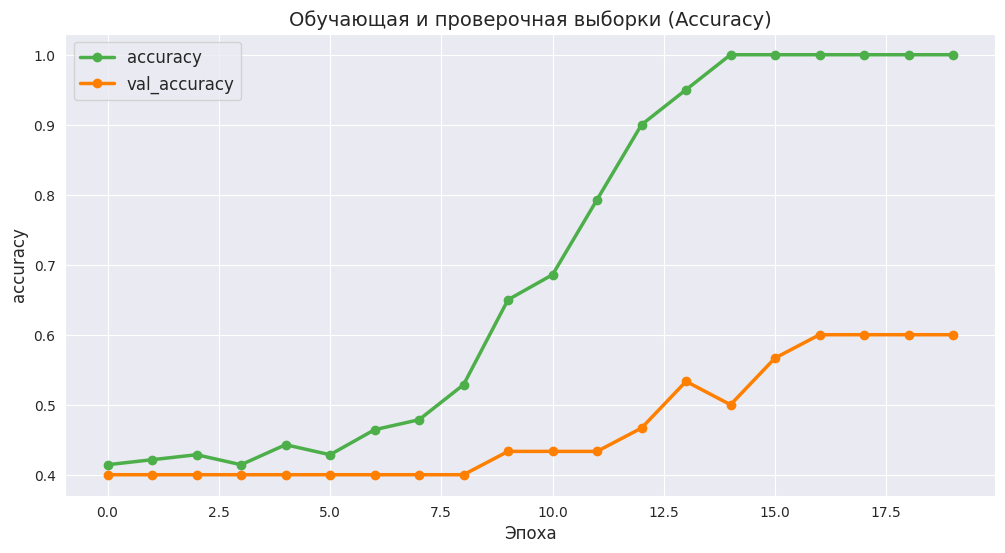

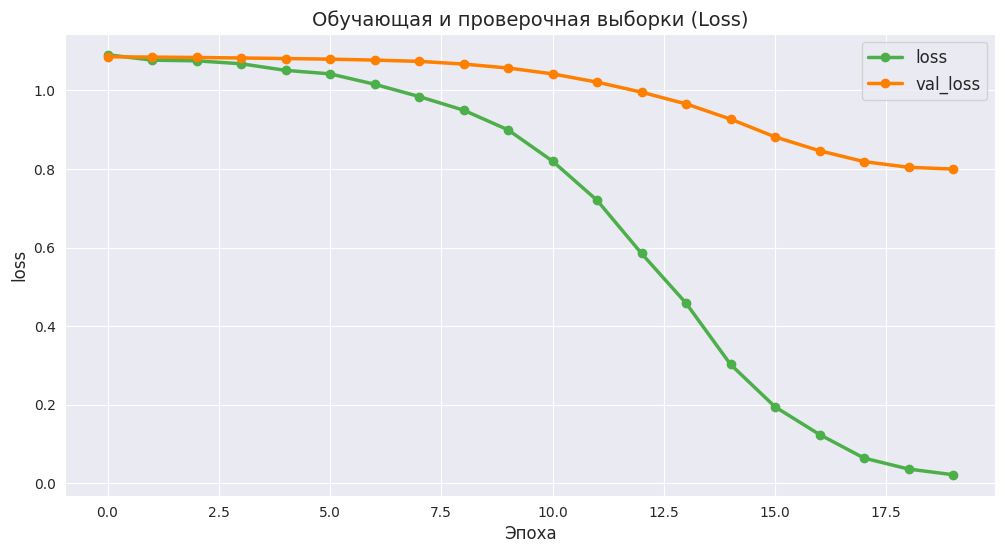

In [ ]:
def plot_graphs(history, key):
    sns.set_style('darkgrid')
    palette = sns.color_palette('Set1')
    plt.figure(figsize=(12,6))
    plt.plot(history.history[key], marker='o', color=palette[2], linewidth=2.5, label=key)
    if 'val_'+key in history.history:
        plt.plot(history.history['val_'+key], marker='o', color=palette[4], linewidth=2.5, label='val_'+key)
    plt.xlabel("Эпоха", fontsize=12)
    plt.ylabel(key, fontsize=12)
    plt.title('Обучающая и проверочная выборки ('+key.title()+')', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

# Строим графики точности и потерь
plot_graphs(result_training, "accuracy")
plot_graphs(result_training, "loss")


In [ ]:
def predict_ticket_type(text, model):
    result = model.predict(np.array([text]))
    print(f"Предложение: '{text}' классифицировано как: {result[0]}")

# Пример использования функции предсказания
example_request = "icon dear please setup icon per icon engineers please let other details needed thanks lead"
predict_ticket_type(example_request, clf)


1/1 [==============================] - 0s 5ms/step
Предложение: 'icon dear please setup icon per icon engineers please let other details needed thanks lead' классифицировано как: ['Hardware']
